Title: Anaylsis of Churn For Interconnect 

Description: The purpose of this project is to identify customers at risk for churning for the company Interconnect. If a customer is at risk of leaving the company plans to offer promotional codes and special plan options. Interconnect provides two main services landline communication and internet. In addition the company provides device protection, online security, technical support, online backup, TV streaming and movie streaming services. The data provided by Interconnect was obtained from a variety of different sources and the information is valid as of February 1, 2020.  

The project will aim to solve the following concerns: 
1. What are some patterns shared by those who have churned?
2. What is the best machine learning model to accurately predict customer churn?

The objectives of the project will be to: 
1. Identify patterns in behavior and demographics that seperate active customers from churned customers.
2. Design a machine learning model capable of accurately predicting customer churn with an accuracy score of at least .80 and AUC-ROC score of at least .85. 

In [102]:
# Loading Libraries
#Data manipulation & preprocessing of data
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import time
from tqdm.auto import tqdm

#Viewing data
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

#Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

#Model evaluation
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict,GridSearchCV

#Supressing warning messages
import warnings
warnings.filterwarnings('ignore')


#Loading the datasets
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

Preprocessing data: 

In [103]:
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [104]:
#Changing from camal case to snake case for df_contract 
df_contract=df_contract.rename(columns={'customerID':'customer_id','BeginDate':'begin_date','EndDate':'end_date', 'Type':'contract_type','PaperlessBilling':'paperless_billing','PaymentMethod':'payment_method', 'MonthlyCharges':'monthly_charges', 'TotalCharges':'total_charges'})


In [105]:
#Checking on df_contract 
df_contract.head()

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [106]:
#Converting Month-to-month to Monthly 
df_contract['contract_type']= df_contract['contract_type'].where(df_contract['contract_type']!='Month-to-month','Monthly')

In [107]:
#Converting begin_date to datetime 
df_contract['begin_date']= pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')

In [108]:
#Converting end_date to datetime 
df_contract['end_date']= df_contract['end_date'].where(df_contract['end_date']!='No',None)
df_contract['end_date']= pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')

In [109]:
#Create contract time column 
contract_time = ((df_contract['end_date']-df_contract['begin_date'])/np.timedelta64(1,'M'))
df_contract['contract_time_months'] = contract_time.round()

In [110]:
#Create churn column 
df_contract['churn'] = df_contract['contract_time_months']
df_contract['churn'] = df_contract['churn'].fillna(0)
df_contract['churn'] = df_contract['churn'].where(df_contract['churn']<0.5,1)
df_contract['churn'] = df_contract['churn'].astype(int)


In [111]:
# Convert paperless_billing to 1 & 0 
df_contract['paperless_billing']=df_contract['paperless_billing'].where(df_contract['paperless_billing'] !='Yes',1)
df_contract['paperless_billing']=df_contract['paperless_billing'].where(df_contract['paperless_billing'] !='No',0)
df_contract['paperless_billing'] = df_contract['paperless_billing'].astype(int)


In [112]:
#total_charges column type from object to float 
df_contract ['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')

In [113]:
#Reviewing df_contract 
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           7043 non-null   object        
 1   begin_date            7043 non-null   datetime64[ns]
 2   end_date              1869 non-null   datetime64[ns]
 3   contract_type         7043 non-null   object        
 4   paperless_billing     7043 non-null   int64         
 5   payment_method        7043 non-null   object        
 6   monthly_charges       7043 non-null   float64       
 7   total_charges         7032 non-null   float64       
 8   contract_time_months  1869 non-null   float64       
 9   churn                 7043 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(3)
memory usage: 550.4+ KB


,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,contract_time_months,churn
0,7590-VHVEG,2020-01-01,NaT,Monthly,1,Electronic check,29.85,29.85,NaN,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,NaN,0
2,3668-QPYBK,2019-10-01,2019-12-01,Monthly,1,Mailed check,53.85,108.15,2.0,1
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,0
4,9237-HQITU,2019-09-01,2019-11-01,Monthly,1,Electronic check,70.70,151.65,2.0,1


In [114]:
#Checking for duplicates 
df_contract.duplicated().sum()

0

Description: Column names were updated to snake case to support with merging the other dataframes later. In addition, binary data was converted to 1/0 to ensure data is prepared for the model training process. The columns that contained dates were adjusted to datetime format. Two new columns: contract_time_months and churn were devised to support with understanding of client behaviors. 

In [115]:
#Viewing df_personal
df_personal.info()
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [116]:
#Converting column names from camel case to snake case for df_personal 
df_personal = df_personal.rename(columns={'customerID':'customer_id','gender':'gender_male', 'SeniorCitizen':'senior_citizen', 'Partner': 'partner','Dependents':'dependents'})


In [117]:
#Convert gender_male to 1 & 0 
df_personal['gender_male'] = df_personal['gender_male'].where(df_personal['gender_male']!= 'Male',1)
df_personal['gender_male'] = df_personal['gender_male'].where(df_personal['gender_male']!= 'Female',0)
df_personal['gender_male'] = df_personal['gender_male'].astype(int)

In [118]:
#Convert partner to 1 & 0 
df_personal['partner']= df_personal['partner'].where(df_personal['partner']!='Yes',1)
df_personal['partner'] = df_personal['partner'].where(df_personal['partner']!='No',0)
df_personal['partner'] = df_personal['partner'].astype(int)

In [119]:
#Convert dependents to 1 & 0 
df_personal['dependents'] = df_personal['dependents'].where(df_personal['dependents'] != 'Yes',1)
df_personal['dependents'] = df_personal['dependents'].where(df_personal['dependents'] !='No',0)
df_personal['dependents'] = df_personal['dependents'].astype(int)

In [120]:
#Check df_personal 
df_personal.info()
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender_male     7043 non-null   int64 
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   int64 
 4   dependents      7043 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 275.2+ KB


,customer_id,gender_male,senior_citizen,partner,dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0


In [121]:
#Check for duplicates 
df_personal.duplicated().sum()

0

Description:Column names were converted to snake case for later use when the dataframes are merged. The gender column was changed from yes/no values to indicate male as 1 and feamle as 0. Name was subsequently changed to make it clear that 1 was for male and 0 for female. This will ensure that when models are trained the data is consistent. 

In [122]:
#Check on df_internet
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [123]:
#Converting column names from camal case to snake case for df_internet 
df_internet = df_internet.rename(columns={'customerID':'customer_id','InternetService':'internet_service', 'OnlineSecurity':'online_security','OnlineBackup':'online_backup','DeviceProtection':'device_protection', 'TechSupport':'tech_support', 'StreamingTV':'streaming_tv','StreamingMovies': 'streaming_movies'})



In [124]:
#Convert appropriate columns for df_internet to 1 & 0 
df_internet = df_internet.where(df_internet != 'Yes', 1)
df_internet = df_internet.where(df_internet != 'No', 0)
df_internet ['online_security'] = df_internet ['online_security'].astype(int)
df_internet ['online_backup'] = df_internet ['online_backup'].astype(int)
df_internet ['device_protection'] = df_internet ['device_protection'].astype(int)
df_internet ['tech_support'] = df_internet ['tech_support'].astype(int)
df_internet ['streaming_tv'] = df_internet ['streaming_tv'].astype(int)
df_internet ['streaming_movies'] = df_internet ['streaming_movies'].astype(int)

In [125]:
#Create new column got_internet for internet services 
got_internet = df_internet['streaming_movies']
df_internet['got_internet']= got_internet
df_internet ['got_internet'] = df_internet['got_internet'].where(df_internet ['got_internet'] < 0,1)


In [126]:
#Viewing df_internet 
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   int64 
 3   online_backup      5517 non-null   int64 
 4   device_protection  5517 non-null   int64 
 5   tech_support       5517 non-null   int64 
 6   streaming_tv       5517 non-null   int64 
 7   streaming_movies   5517 non-null   int64 
 8   got_internet       5517 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 388.0+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,got_internet
0,7590-VHVEG,DSL,0,1,0,0,0,0,1
1,5575-GNVDE,DSL,1,0,1,0,0,0,1
2,3668-QPYBK,DSL,1,1,0,0,0,0,1
3,7795-CFOCW,DSL,1,0,1,1,0,0,1
4,9237-HQITU,Fiber optic,0,0,0,0,0,0,1


In [127]:
df_internet.duplicated().sum()

0

Description: Column names were converted to snake script to support later dataframe merging. Moreover, yes/no values were updated to be 1/0. An additional column called got_internet was added to indicate if clients had purchased the internet service. This was added for ease of use later. 

In [128]:
#Review df_phone
df_phone.info()
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [129]:
#Converting from camel case to snake case 
df_phone = df_phone.rename(columns={'customerID' : 'customer_id', 'MultipleLines' : 'multiple_lines'})


In [130]:
#Convert multiple_lines to 1 & 0 
df_phone = df_phone.where(df_phone != 'Yes', 1)
df_phone = df_phone.where(df_phone != 'No', 0)
df_phone['multiple_lines'] = df_phone['multiple_lines'].astype(int)


In [131]:
# feature engineering: add a column to indicate phone_services 
phone_serv = df_phone['multiple_lines'] 
df_phone ['phone_serv'] = phone_serv
df_phone ['phone_serv'] = df_phone ['phone_serv'].where(df_phone ['phone_serv'] < 0, 1)


In [132]:
#Check on df_phone
df_phone.info()
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   int64 
 2   phone_serv      6361 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 149.2+ KB


,customer_id,multiple_lines,phone_serv
0,5575-GNVDE,0,1
1,3668-QPYBK,0,1
2,9237-HQITU,0,1
3,9305-CDSKC,1,1
4,1452-KIOVK,1,1


In [133]:
df_phone.duplicated().sum()

0

Description: Column names have been updated to snake case from camel case to promote consistency. The yes/no values have been updated to 1/0 for the purpose of consistency as well. The next step will be to merge the dataframes for usability purposes. 

In [134]:
#Merging dataframes 
df_merged = df_contract.merge(df_personal, on='customer_id', how='outer')
df_merged = df_merged.merge(df_internet, on='customer_id', how='outer')
df_merged = df_merged.merge(df_phone, on='customer_id', how='outer')

In [135]:
#Checking merged dataframe 
df_merged.info()
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           7043 non-null   object        
 1   begin_date            7043 non-null   datetime64[ns]
 2   end_date              1869 non-null   datetime64[ns]
 3   contract_type         7043 non-null   object        
 4   paperless_billing     7043 non-null   int64         
 5   payment_method        7043 non-null   object        
 6   monthly_charges       7043 non-null   float64       
 7   total_charges         7032 non-null   float64       
 8   contract_time_months  1869 non-null   float64       
 9   churn                 7043 non-null   int64         
 10  gender_male           7043 non-null   int64         
 11  senior_citizen        7043 non-null   int64         
 12  partner               7043 non-null   int64         
 13  dependents        

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,contract_time_months,churn,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,got_internet,multiple_lines,phone_serv
0,7590-VHVEG,2020-01-01,NaT,Monthly,1,Electronic check,29.85,29.85,NaN,0,...,DSL,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,NaN,0,...,DSL,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3668-QPYBK,2019-10-01,2019-12-01,Monthly,1,Mailed check,53.85,108.15,2.0,1,...,DSL,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,0,...,DSL,1.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Monthly,1,Electronic check,70.70,151.65,2.0,1,...,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [136]:
#Checking for missing values 
df_merged.isna().sum()

customer_id                0
begin_date                 0
end_date                5174
contract_type              0
paperless_billing          0
payment_method             0
monthly_charges            0
total_charges             11
contract_time_months    5174
churn                      0
gender_male                0
senior_citizen             0
partner                    0
dependents                 0
internet_service        1526
online_security         1526
online_backup           1526
device_protection       1526
tech_support            1526
streaming_tv            1526
streaming_movies        1526
got_internet            1526
multiple_lines           682
phone_serv               682
dtype: int64

Description: end_date and contract_time_months will retain missing values as these particular columns refer to customers who haved churned. The other columns with missing values will need to be addressed according to their particular data contents. 

In [137]:
#Checking for duplicates 
df_merged.duplicated().sum()

0

In [138]:
#Examining column begin_date minimum 
df_merged ['begin_date'].min()

Timestamp('2013-10-01 00:00:00')

In [139]:
#Examining column begin_date maximum
df_merged ['begin_date'].max()

Timestamp('2020-02-01 00:00:00')

In [140]:
#Addressing missing values in total_charges 
df_merged['total_charges'] = df_merged['total_charges'].fillna(0)

In [141]:
#Addressing missing values in internet_service 
df_merged['internet_service'] = df_merged['internet_service'].fillna('None')

In [142]:
#Addressing missing values in online_security 
df_merged['online_security'] = df_merged['online_security'].fillna(0)
df_merged['online_security'] = df_merged['online_security'].astype(int)

In [143]:
#Addressing missing values in online_backup
df_merged['online_backup'] = df_merged['online_backup'].fillna(0)
df_merged['online_backup'] = df_merged['online_backup'].astype(int)

In [144]:
#Addressing missing values in device_protection
df_merged['device_protection'] = df_merged['device_protection'].fillna(0)
df_merged['device_protection'] = df_merged['device_protection'].astype(int)

In [145]:
#Addressing missing values in tech_support 
df_merged['tech_support'] = df_merged['tech_support'].fillna(0)
df_merged['tech_support'] = df_merged['tech_support'].astype(int)

In [146]:
#Addressing missing values in streaming_tv
df_merged['streaming_tv'] = df_merged['streaming_tv'].fillna(0)
df_merged['streaming_tv'] = df_merged['streaming_tv'].astype(int)

In [147]:
#Addressing missing values in streaming_movies
df_merged['streaming_movies'] = df_merged['streaming_movies'].fillna(0)
df_merged['streaming_movies'] = df_merged['streaming_movies'].astype(int)

In [148]:
#Addressing missing values in got_internet 
df_merged['got_internet'] = df_merged['got_internet'].fillna(0)
df_merged['got_internet'] = df_merged['got_internet'].astype(int)

In [149]:
#Addressing missing values in multiple_lines 
df_merged['multiple_lines'] = df_merged['multiple_lines'].fillna(0)
df_merged['multiple_lines'] = df_merged['multiple_lines'].astype(int)

In [150]:
#Addressing missing values in phone_serv
df_merged['phone_serv'] = df_merged['phone_serv'].fillna(0)
df_merged['phone_serv'] = df_merged['phone_serv'].astype(int)

In [151]:
#Checking for missing values in df_merged 
df_merged.isna().sum()

customer_id                0
begin_date                 0
end_date                5174
contract_type              0
paperless_billing          0
payment_method             0
monthly_charges            0
total_charges              0
contract_time_months    5174
churn                      0
gender_male                0
senior_citizen             0
partner                    0
dependents                 0
internet_service           0
online_security            0
online_backup              0
device_protection          0
tech_support               0
streaming_tv               0
streaming_movies           0
got_internet               0
multiple_lines             0
phone_serv                 0
dtype: int64

In [152]:
#Checking for duplicated values in df_merged 
df_merged.duplicated().sum()

0

Description: The necessary preprocessing was completed for the merged dataframe. Missing values for end_date and contract_time_months will need to retain their missing values as this indicates that a customer has churned. While, missing values for internet_service, online_security, online_backup,device_protection, tech_support, streaming_tv, streaming_movies, and multiple_lines needed to be filled with 0 to indicate the customer did not have that service. For the column internet_service it was kept in a string to ensure that the information was retained. Therefore, the missing values were filled in with "None" to indicate no service was being provided. 

In examining the customer_ids and total_charges column it becomes clear that the latest date is 2020-02-01. This shows that the customer has signed up for service, but not been charged, yet. 

EDA: Exploratory Data Analysis  

<function matplotlib.pyplot.show(close=None, block=None)>

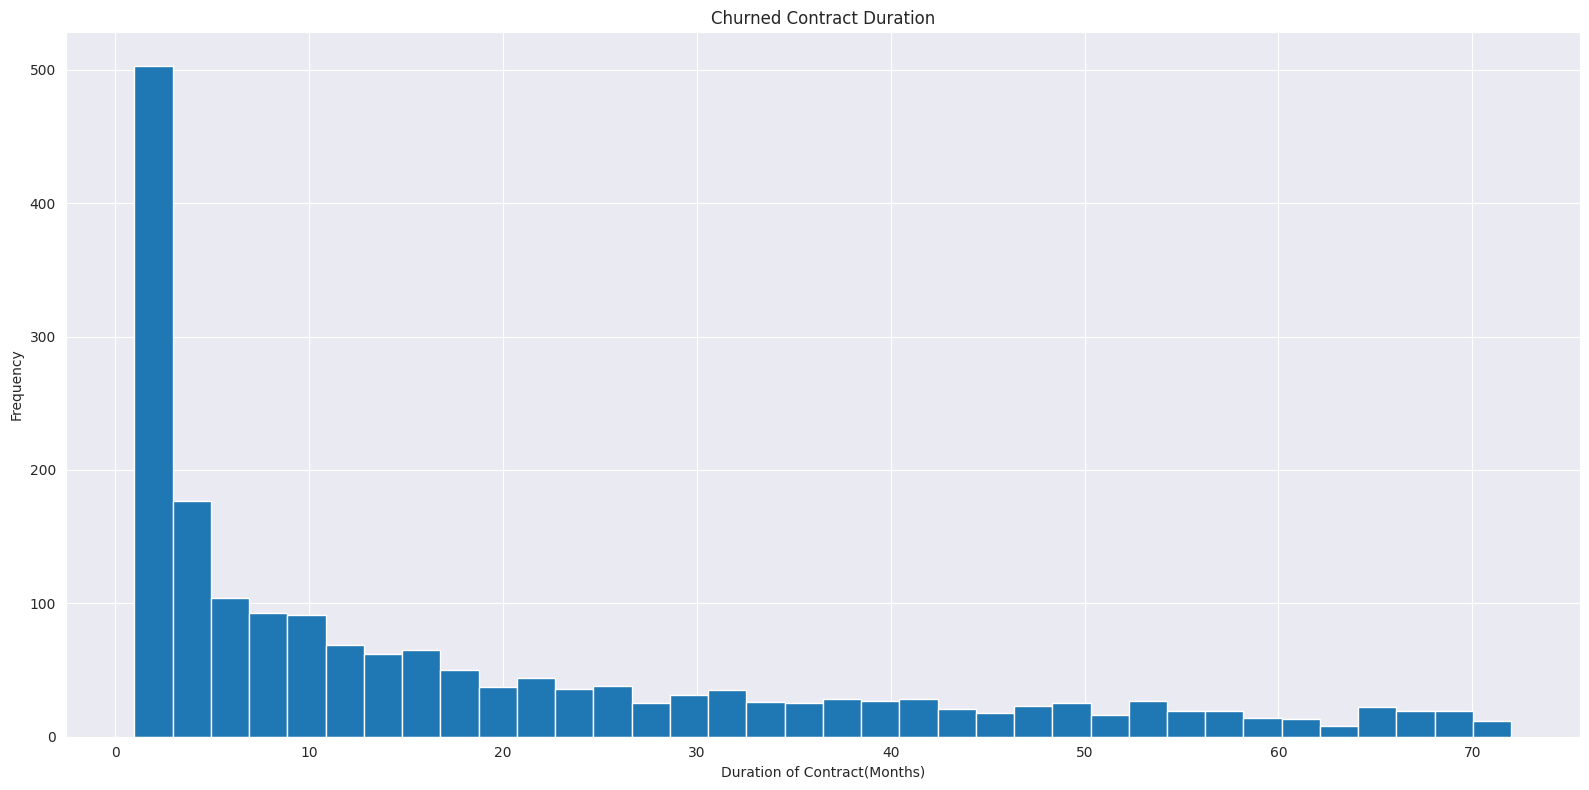

In [153]:
df_merged['contract_time_months'].plot(kind='hist', bins=36, title='Churned Contract Duration', figsize=[16,8])
plt.xlabel('Duration of Contract(Months)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show


Description: Majority of customers who ended their contract did so within the first few months. In addition those that ended the contract did so within the first year of service. Next, we will see if time of year made any difference in a customer churning. 

In [154]:
#Devise a function to automate EDA process

def plot_filled_bar_chart(data, x,title,legend=True):

    palette = ['seagreen','dodgerblue']
    sns.histplot(data=data, x=x,hue='churn',multiple='fill',discrete=True, palette=palette, legend=legend, ax=ax)

    ax.set_title(title,fontweight='bold',y=1.0)
    ax.set_xlabel('')
    ax.set_ylabel('Percentage',fontweight='bold')
    ax.set_yticks(np.linspace(0,1,6))
    ax.set_yticklabels(np.arange(0,101,20))

    if legend == True:
        legend_labels = ['active', 'churn']
        legend_handles = [Line2D([0],[0], color=palette[0], lw=3), Line2D([0],[0],color=palette[1], lw=3)]
        ax.legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))
    

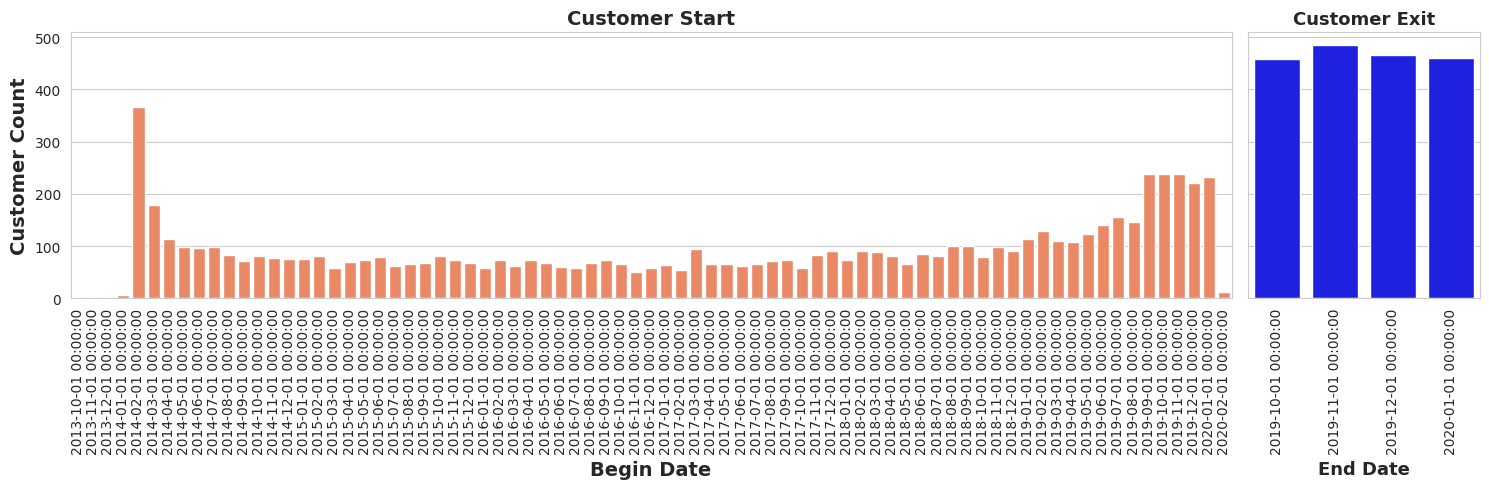

In [155]:
#Examining customer enterance and exit dates 
sns.set_style('whitegrid')
fig, axs = plt.subplots(1,2,gridspec_kw={'width_ratios':[5.0,1.0]}, sharey=True, figsize=(15,5))

#The enterance dates 
df_e = df_merged['begin_date'].value_counts().sort_index()
ax = axs[0]
sns.barplot(x=df_e.index, y=df_e.values,color='coral',ax=ax)
ax.set_title('Customer Start', fontsize=14, fontweight='bold')
ax.set_xlabel('Begin Date',fontsize=14, fontweight='bold')
ax.set_ylabel('Customer Count',fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#Exit dates 
df_e = df_merged ['end_date'].value_counts().sort_index()
ax = axs[1]
sns.barplot(x=df_e.index, y=df_e.values, color='blue', ax=ax)
ax.set_title('Customer Exit', fontsize=13, fontweight='bold')
ax.set_xlabel('End Date',fontsize=13, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()



Description: In examining the data a large portion of customers started to leave in October of 2019 up until January 2020. During this period the number of customers leaving is greater than the cusomters joining. Most customers joined in Feburary of 2014 after which time the number of customers joined at a more consistent rate per month. The average number of customers joining per month is approximately 100 customers per month. 

In [156]:
#Create statistical summary comparison table for monthly charges 
stats = pd.concat([
    df_merged.query('churn==0')['monthly_charges'].describe(), 
    df_merged.query('churn==1')['monthly_charges'].describe()
], axis=1).round(2)

stats.columns = ['active','churned']

stats
                    

,active,churned
count,5174.00,1869.00
mean,61.27,74.44
std,31.09,24.67
min,18.25,18.85
25%,25.10,56.15
50%,64.43,79.65
75%,88.40,94.20
max,118.75,118.35


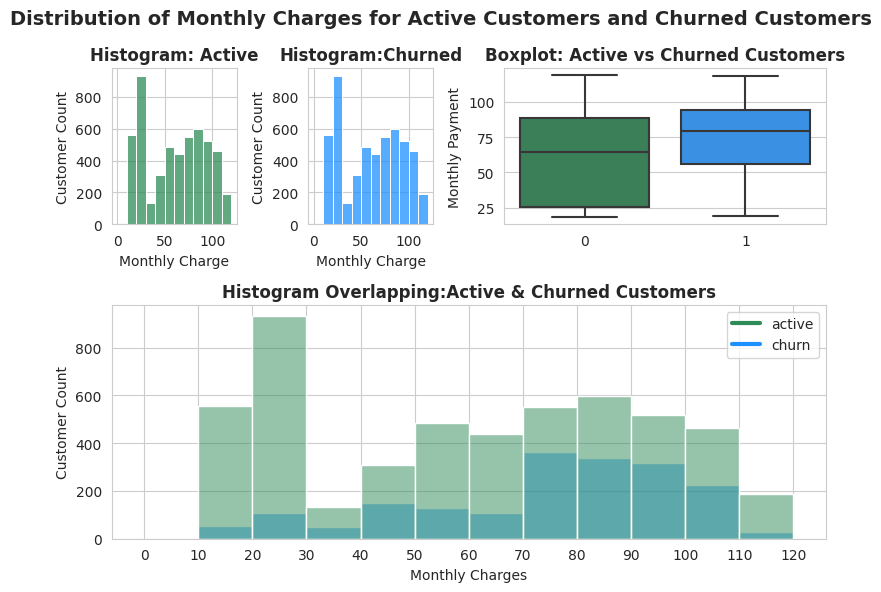

In [157]:
#Devise histograms & boxplots to visualize patterns 

sns.set_style('whitegrid')

layout = """
abcc
dddd
"""
fig, axd = plt.subplot_mosaic(layout, gridspec_kw={'height_ratios': [1.0, 1.5,]}, 
                             figsize=(8,6))

fig.suptitle('Distribution of Monthly Charges for Active Customers and Churned Customers',
            fontsize=14, fontweight='bold')

ax=axd['a']
sns.histplot(data=df_merged.query('churn ==0'), x='monthly_charges',color='seagreen',
            bins=np.arange(0,121,10),ax=ax)
ax.set_title('Histogram: Active', fontweight='bold')
ax.set_xlabel('Monthly Charge')
ax.set_ylabel('Customer Count')

ax = axd['b']
sns.histplot(data=df_merged.query('churn ==0'), x='monthly_charges',color='dodgerblue',
            bins=np.arange(0,121,10),ax=ax)
ax.set_title('Histogram:Churned', fontweight='bold')
ax.set_xlabel('Monthly Charge')
ax.set_ylabel('Customer Count')

ax = axd['c']
sns.boxplot(data=df_merged, x='churn', y='monthly_charges', 
            palette=['seagreen', 'dodgerblue'], ax=ax)
ax.set_title('Boxplot: Active vs Churned Customers', fontweight='bold')
ax.set_xticks([0,1],['active','churn'])
ax.set_xlabel('')
ax.set_ylabel('Monthly Payment')

ax = axd['d']
sns.histplot(data=df_merged, x='monthly_charges',hue='churn',
            bins=np.arange(0, 121, 10),palette=['seagreen', 'dodgerblue'],ax=ax)
legend_labels = ['active','churn']
legend_handles = [Line2D([0],[0], color = 'seagreen', lw=3), Line2D([0],[0], color = 'dodgerblue', lw=3)]
ax.set_title ('Histogram Overlapping:Active & Churned Customers', fontweight='bold')
ax.set_xlabel ('Monthly Charges')
ax.set_ylabel ('Customer Count')
ax.set_xticks(np.arange(0,121,10))
ax.set_xticklabels(np.arange(0,121,10))
ax.legend(legend_handles,legend_labels, loc = 'upper right')

plt.tight_layout()
plt.show()

Description: It can be observed that the customers with the highest monthly charges left. Those customers who remained active had a smaller monthly charge. The monthly charges can be grouped into 4 ranges: 0-40, 40-70, 70-110, and 110 and above. It will be useful to take a closer examination of this data by creating a visual to display these ranges compared to the churn. 

In [158]:
#Create statistical summary comparison table for each group of monthly payment
stats_mp = pd.cut(
    df_merged['monthly_charges'],
    bins=[0,40,70,110,120],
    labels=['0-40','40-70','70-110','110 and above']
).to_frame()

stats_mp['churn'] = df_merged['churn']

pivot_table_mp = stats_mp.pivot_table(
    index='monthly_charges',
    columns='churn',
    aggfunc='size'
)

pivot_perc = (pivot_table_mp.div(pivot_table_mp.sum(axis=1), axis=0)*100).round(2)

pivot_perc

churn,0,1
monthly_charges,,
0-40,88.36,11.64
40-70,76.08,23.92
70-110,63.21,36.79
110 and above,86.98,13.02


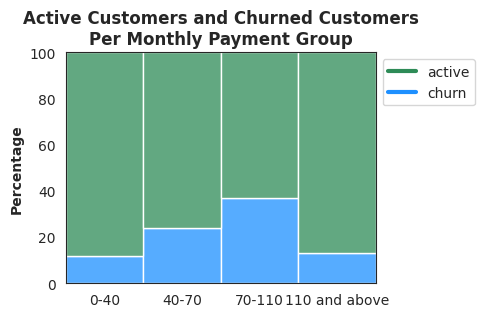

In [159]:
#Create bar chart for monthly charges 
sns.set_style('white')
plt.figure(figsize=(4, 3))

ax=plt.gca()
plot_filled_bar_chart(data=stats_mp,
              x='monthly_charges',
              title='Active Customers and Churned Customers\nPer Monthly Payment Group')
plt.show()

Description: The customers who had a monthly charged 70-110 had the most signficant churn rate of approximately 35% with the next highest churn rate being those in the 40-70 at approximately 25%. It will be key to see if contract type makes any difference as well in the rate of churn. 

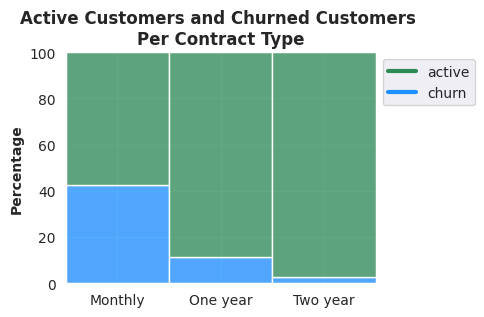

In [160]:
#Churn rate per contract type devise a filled bar chart 
sns.set_style('darkgrid')
plt.figure(figsize=(4,3))

ax=plt.gca()
plot_filled_bar_chart(data=df_merged,
                     x='contract_type',
                     title='Active Customers and Churned Customers \nPer Contract Type')
plt.show()


Description: The churn rate for customers who are on a month to month contract is at approximately 40% which is nearly 4 time higher than all other contract types. 

In [161]:
#Devise pivot table to examine payment methods 
payment_methods = df_merged.pivot_table(columns='churn',
                                       index='payment_method',
                                       values='contract_type',
                                       aggfunc='count'
                                       )
payment_methods.reset_index(inplace=True)
payment_methods 

churn,payment_method,0,1
0,Bank transfer (automatic),1286,258
1,Credit card (automatic),1290,232
2,Electronic check,1294,1071
3,Mailed check,1304,308


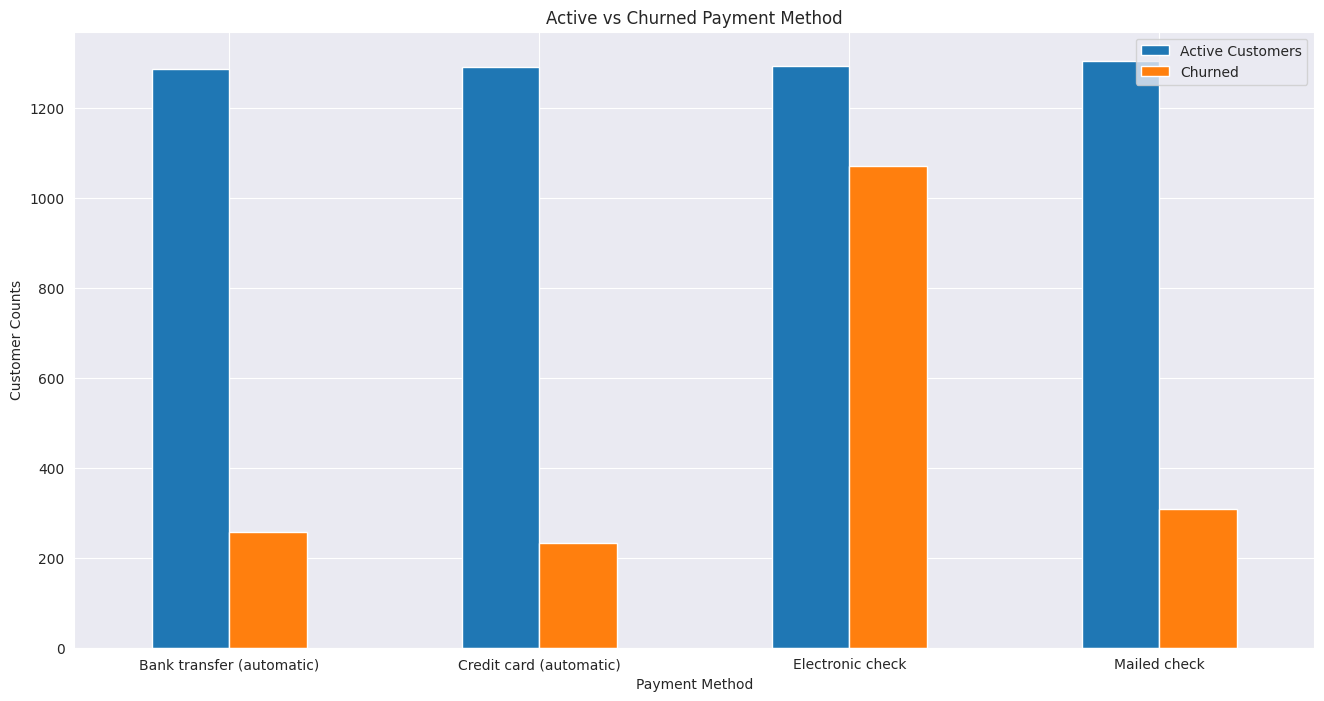

In [162]:
# Create bar chart for payment methods 
payment_methods.plot(kind='bar',
                    x='payment_method',
                    title='Active vs Churned Payment Method',
                    figsize=[16,8],
                    )
plt.xticks(rotation=0)
plt.xlabel('Payment Method')
plt.ylabel('Customer Counts')
plt.legend(['Active Customers','Churned'])
plt.show()

Description: In examining the churn patterns based on payment methods it becomes noticiable that electronic check users had the highest churn rate at nearly 45%. In comparison those who paid via automatic bank transfer had the lowest churn rate at approximately 15%. 

In [163]:
# Create pivot table for internet service 
internet_connections = df_merged.pivot_table(columns='churn',
                     index='internet_service',
                     values='customer_id',
                     aggfunc='count'
                     )
internet_connections.reset_index(inplace=True)
internet_connections

churn,internet_service,0,1
0,DSL,1962,459
1,Fiber optic,1799,1297
2,None,1413,113


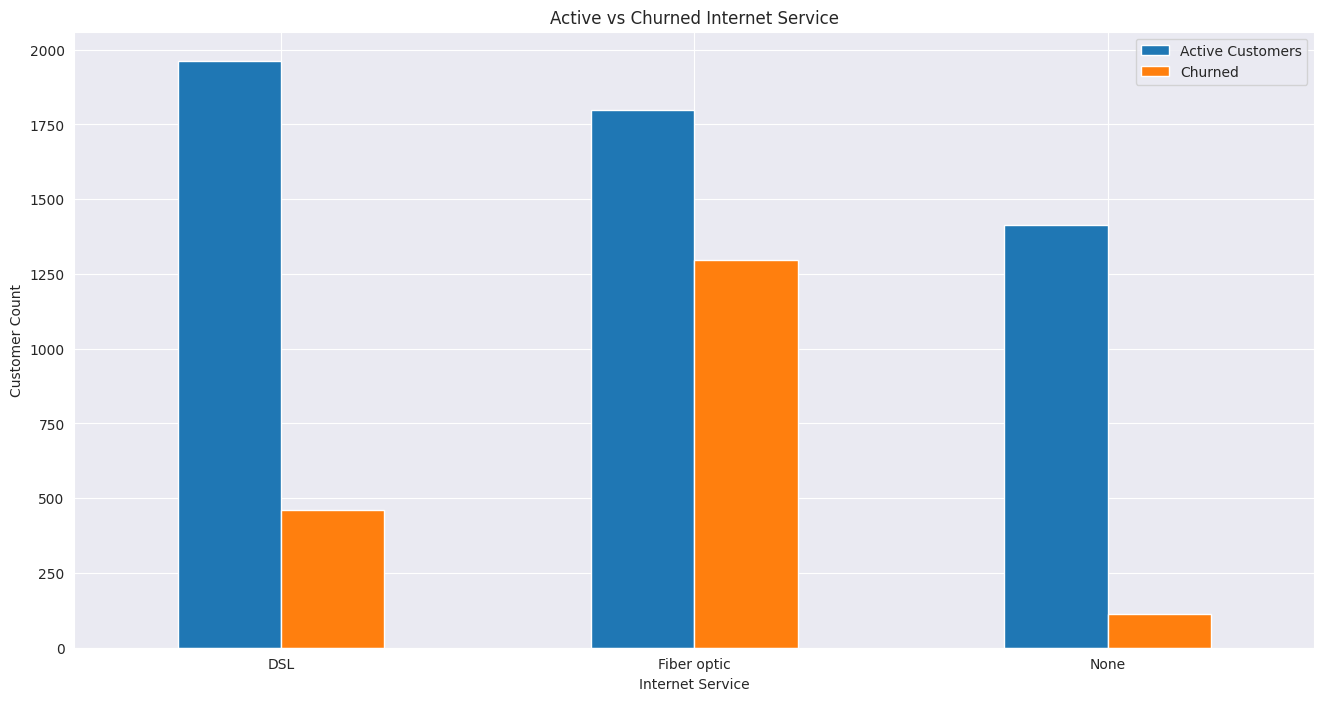

In [164]:
# Create bar chart for internet service 
internet_connections.plot(kind='bar',
                         x='internet_service',
                         title='Active vs Churned Internet Service',
                         figsize=[16,8],
                         )
plt.xticks(rotation=0)
plt.xlabel('Internet Service')
plt.ylabel('Customer Count')
plt.legend(['Active Customers','Churned'])
plt.show()

Description: The Fiber Optics customers had the highest churn rate at nearly 42%, compared to the DSL's who had a churn rate of approximately 20%. This illustrates that the type of internet service may play a role in customer retention. 

In [165]:
# Create pivot table for contract type based on internet service provided 
contract = df_merged.pivot_table(columns='contract_type',
                     index='internet_service',
                     values='customer_id',
                     aggfunc='count'
                     )
contract.reset_index(inplace=True)
contract

contract_type,internet_service,Monthly,One year,Two year
0,DSL,1223,570,628
1,Fiber optic,2128,539,429
2,None,524,364,638


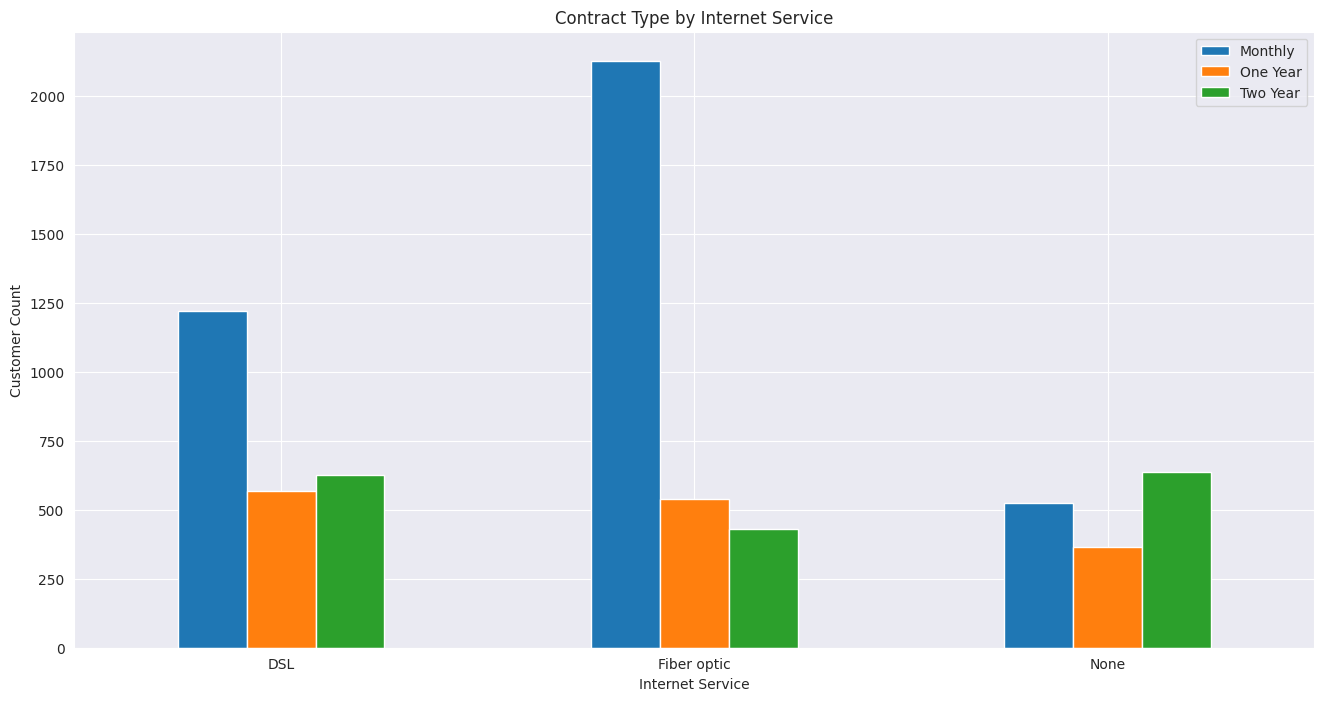

In [166]:
#Create bar chart for contact type by internet service 
contract.plot(kind='bar', 
              x='internet_service',
              title='Contract Type by Internet Service',
              figsize=[16,8],
            )
plt.xticks(rotation=0)
plt.xlabel('Internet Service')
plt.ylabel('Customer Count')
plt.legend(['Monthly','One Year','Two Year'])
plt.show()

Description: This bar graph illustrates several trends:
1. Fiber Optic and DSL customers prefer flexibility as many prefer the short term contract. 
2. Longerterm customers prefer more basic services such as no internet.
3. Monthly contracts are the most popular illustrating a greater demand for short term flexibility. 

In [167]:
# Create pivot tables for various service features for active vs churned 
security = df_merged.pivot_table(columns='churn',
                     index='online_security',
                     values='monthly_charges',
                     aggfunc='count'
                     )
security.reset_index(inplace=True)


backup = df_merged.pivot_table(columns='churn',
                     index='online_backup',
                     values='monthly_charges',
                     aggfunc='count'
                     )
backup.reset_index(inplace=True)


device = df_merged.pivot_table(columns='churn',
                     index='device_protection',
                     values='monthly_charges',
                     aggfunc='count'
                     )
device.reset_index(inplace=True)


tech_help= df_merged.pivot_table(columns='churn',
                     index='tech_support',
                     values='monthly_charges',
                     aggfunc='count'
                     )
tech_help.reset_index(inplace=True)


tv = df_merged.pivot_table(columns='churn',
                     index='streaming_tv',
                     values='monthly_charges',
                     aggfunc='count'
                     )
tv.reset_index(inplace=True)


movie = df_merged.pivot_table(columns='churn',
                     index='streaming_movies',
                     values='monthly_charges',
                     aggfunc='count'
                     )
movie.reset_index(inplace=True) 


lines = df_merged.pivot_table(columns='churn',
                     index='multiple_lines',
                     values='monthly_charges',
                     aggfunc='count'
                     )
lines.reset_index(inplace=True)


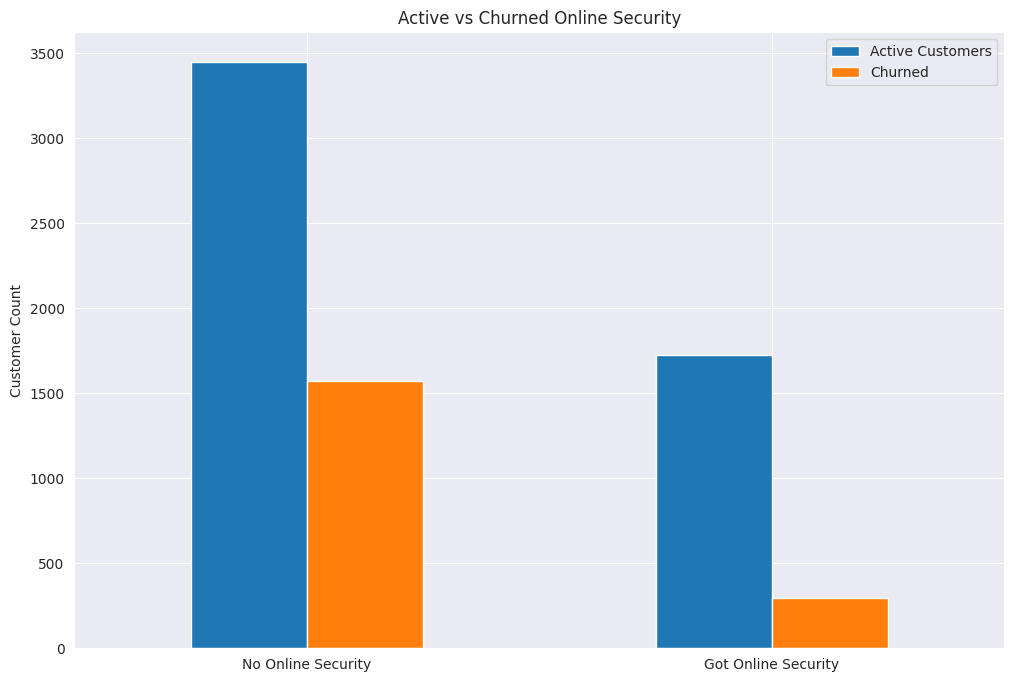

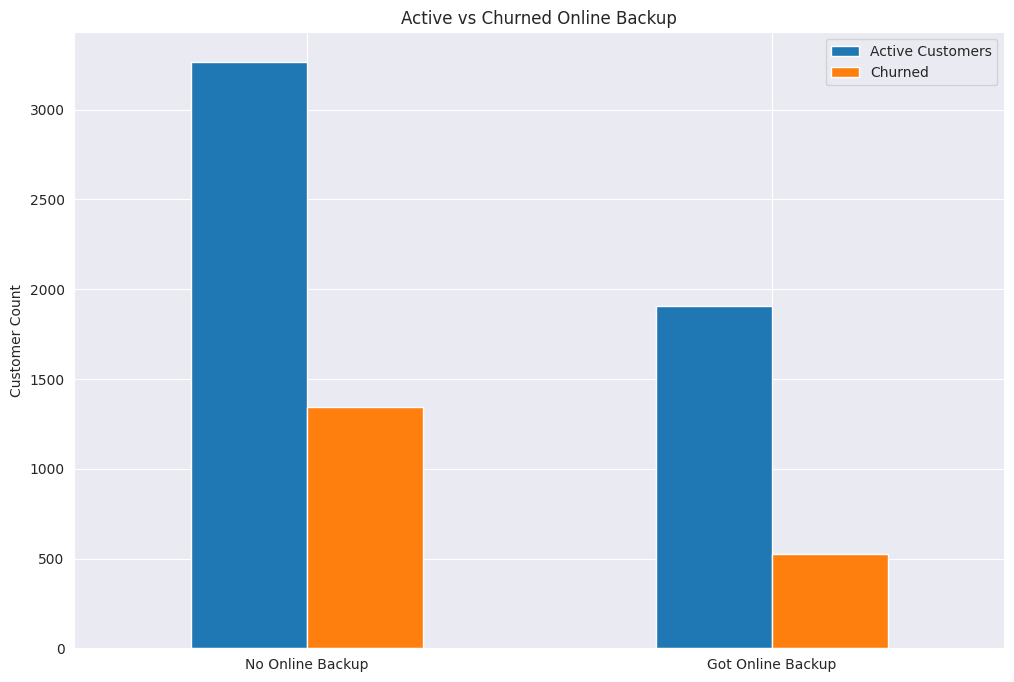

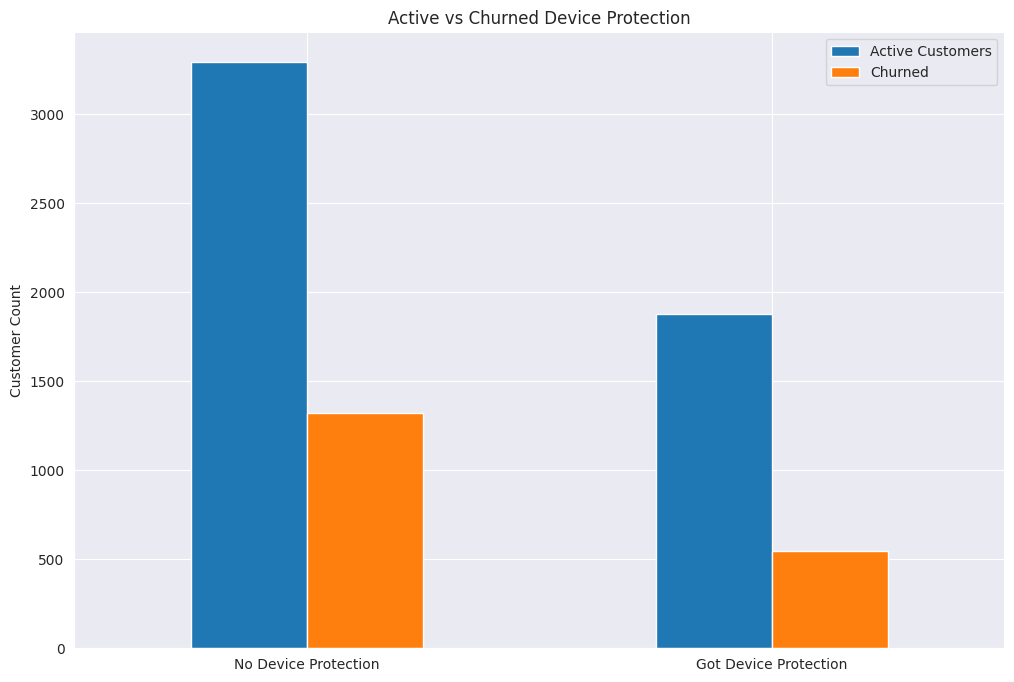

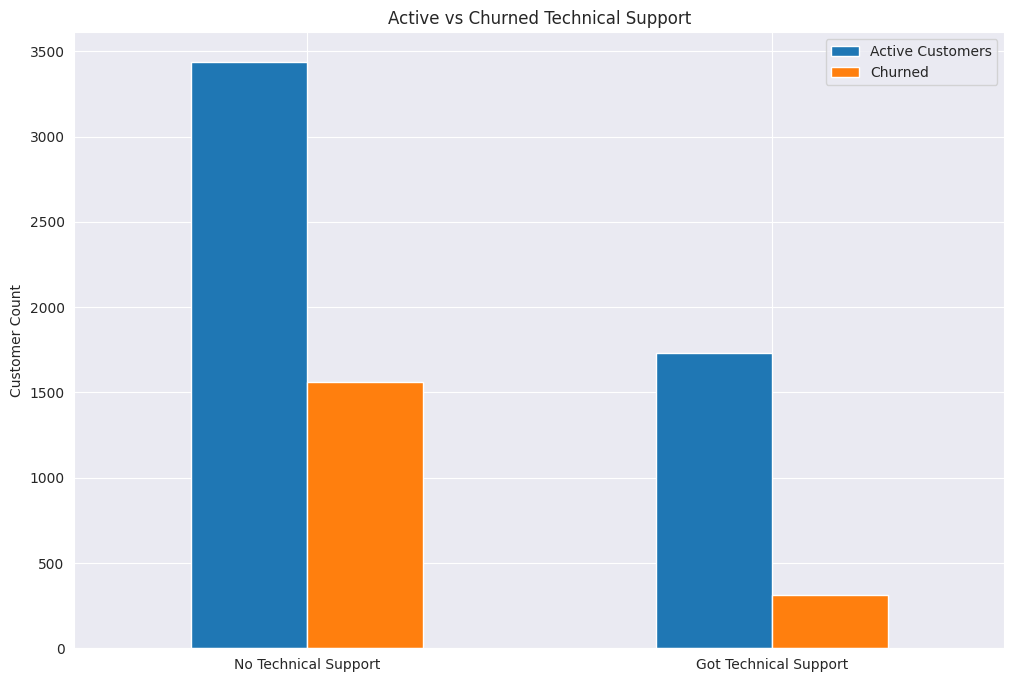

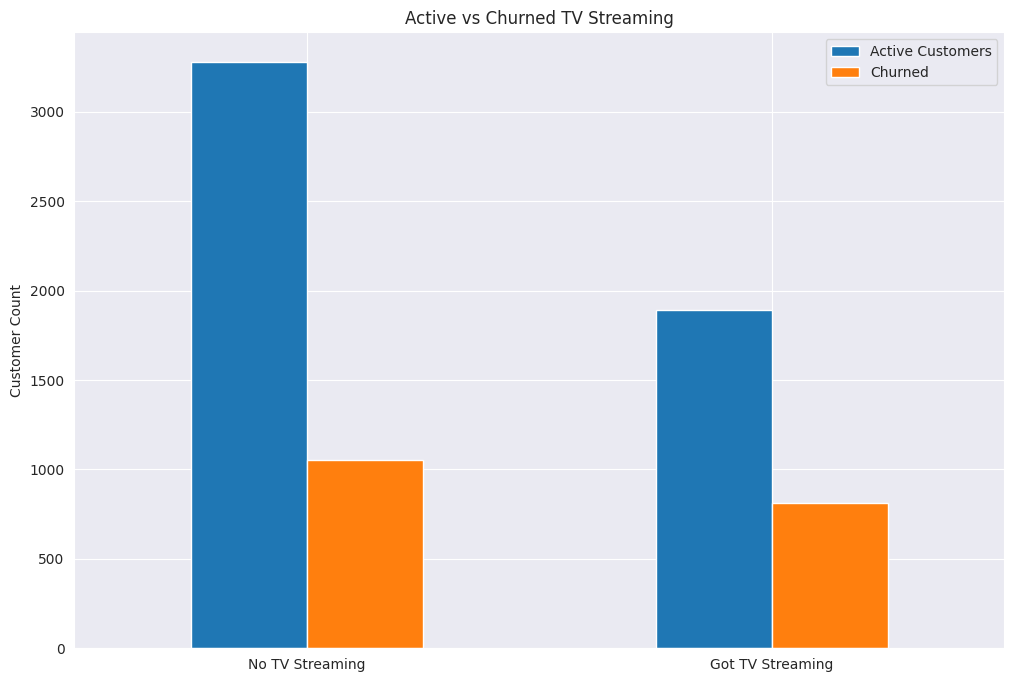

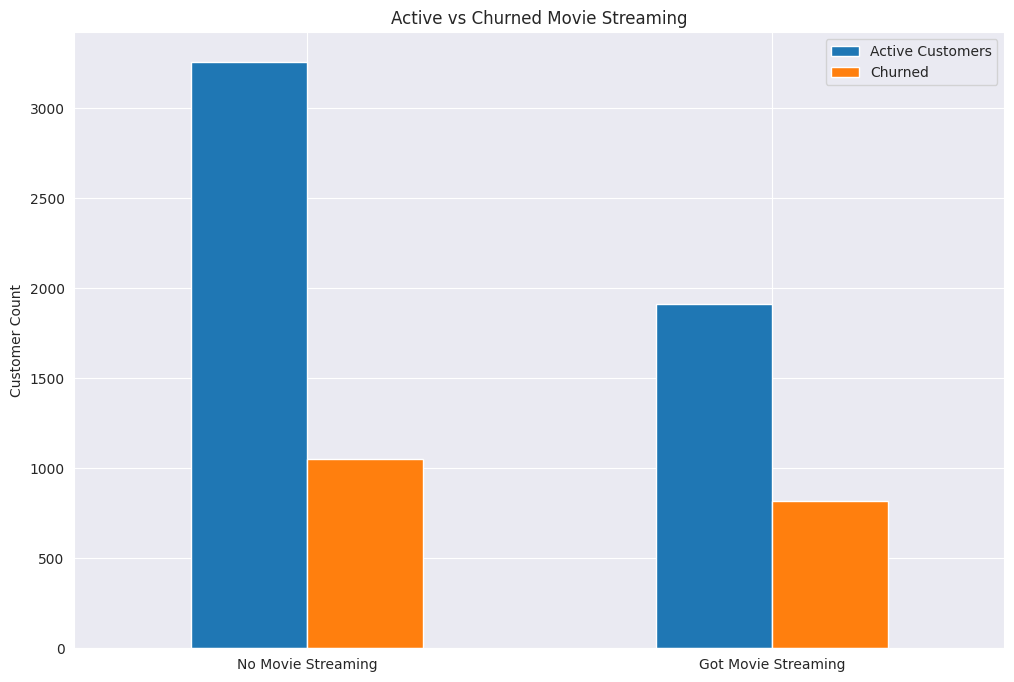

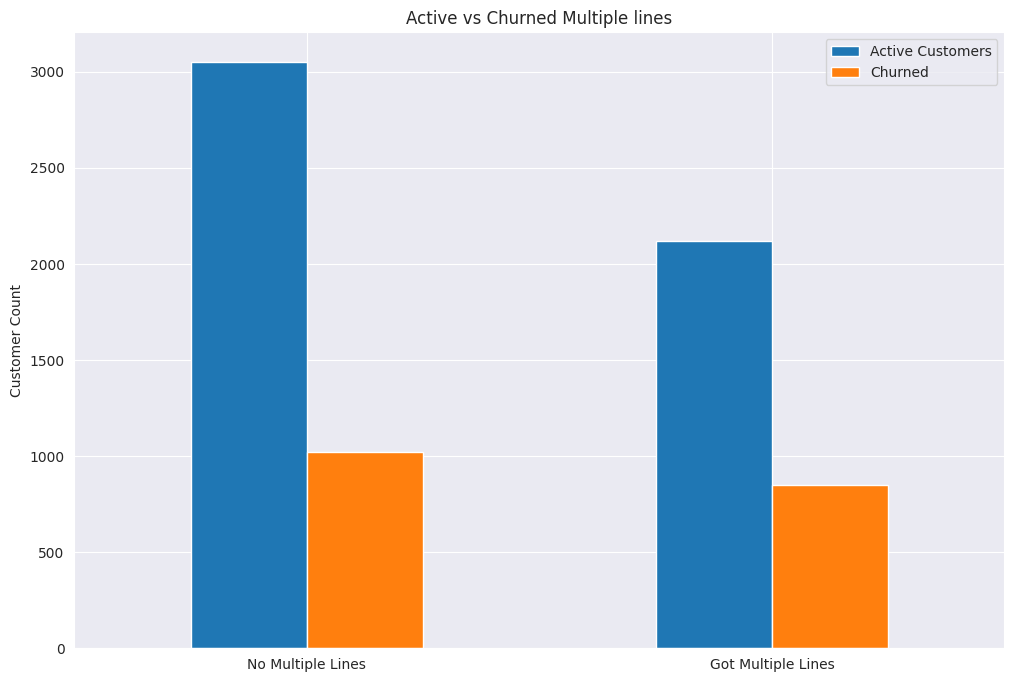

In [168]:
# Create bar charts for various service features for active vs churned 
security.plot(kind='bar',
             x='online_security',
             title='Active vs Churned Online Security',
             figsize=[12,8]
             )
plt.xticks([0,1],['No Online Security', 'Got Online Security'], rotation=0)
plt.xlabel('')
plt.ylabel('Customer Count')
plt.legend(['Active Customers', 'Churned'])

backup.plot(kind='bar',
             x='online_backup',
             title='Active vs Churned Online Backup',
             figsize=[12,8]
             )
plt.xticks([0,1],['No Online Backup', 'Got Online Backup'], rotation=0)
plt.xlabel('')
plt.ylabel('Customer Count')
plt.legend(['Active Customers', 'Churned'])

device.plot(kind='bar',
             x='device_protection',
             title='Active vs Churned Device Protection',
             figsize=[12,8]
             )
plt.xticks([0,1],['No Device Protection', 'Got Device Protection'], rotation=0)
plt.xlabel('')
plt.ylabel('Customer Count')
plt.legend(['Active Customers', 'Churned'])

tech_help.plot(kind='bar',
             x='tech_support',
             title='Active vs Churned Technical Support',
             figsize=[12,8]
             )
plt.xticks([0,1],['No Technical Support', 'Got Technical Support'], rotation=0)
plt.xlabel('')
plt.ylabel('Customer Count')
plt.legend(['Active Customers', 'Churned'])

tv.plot(kind='bar',
             x='streaming_tv',
             title='Active vs Churned TV Streaming',
             figsize=[12,8]
             )
plt.xticks([0,1],['No TV Streaming', 'Got TV Streaming'], rotation=0)
plt.xlabel('')
plt.ylabel('Customer Count')
plt.legend(['Active Customers', 'Churned'])

movie.plot(kind='bar',
             x='streaming_movies',
             title='Active vs Churned Movie Streaming',
             figsize=[12,8]
             )
plt.xticks([0,1],['No Movie Streaming', 'Got Movie Streaming'], rotation=0)
plt.xlabel('')
plt.ylabel('Customer Count')
plt.legend(['Active Customers', 'Churned'])

lines.plot(kind='bar',
             x='multiple_lines',
             title='Active vs Churned Multiple lines',
             figsize=[12,8]
             )
plt.xticks([0,1],['No Multiple Lines', 'Got Multiple Lines'], rotation=0)
plt.xlabel('')
plt.ylabel('Customer Count')
plt.legend(['Active Customers', 'Churned'])

Description: Customers who used online security, online backup, device protection and technical support tended to have a lower churn rate as opposed to those who did not recieve these services. Conversly, the services of TV streaming, movie streaming, and multiple lines had a higher churn rate amongst the users. Although, it is not a signficant rate with the typical range being observed. It is unlikely that a direct correlation exist between specific services and customer churn rates. 

In [169]:
# Create pivot tables for various customer demographics 
gender = df_merged.pivot_table(columns = 'churn',
                              index = 'gender_male',
                              values='monthly_charges',
                              aggfunc='count'
                              )
gender.reset_index(inplace=True)

senior = df_merged.pivot_table(columns = 'churn',
                              index = 'senior_citizen',
                              values='monthly_charges',
                              aggfunc='count'
                              )
senior.reset_index(inplace=True)

partnership = df_merged.pivot_table(columns = 'churn',
                               index='partner',
                               values='monthly_charges',
                               aggfunc='count')
partnership.reset_index(inplace=True)

dependent = df_merged.pivot_table(columns = 'churn',
                              index = 'dependents',
                              values='monthly_charges',
                              aggfunc='count'
                              )
dependent.reset_index(inplace=True)


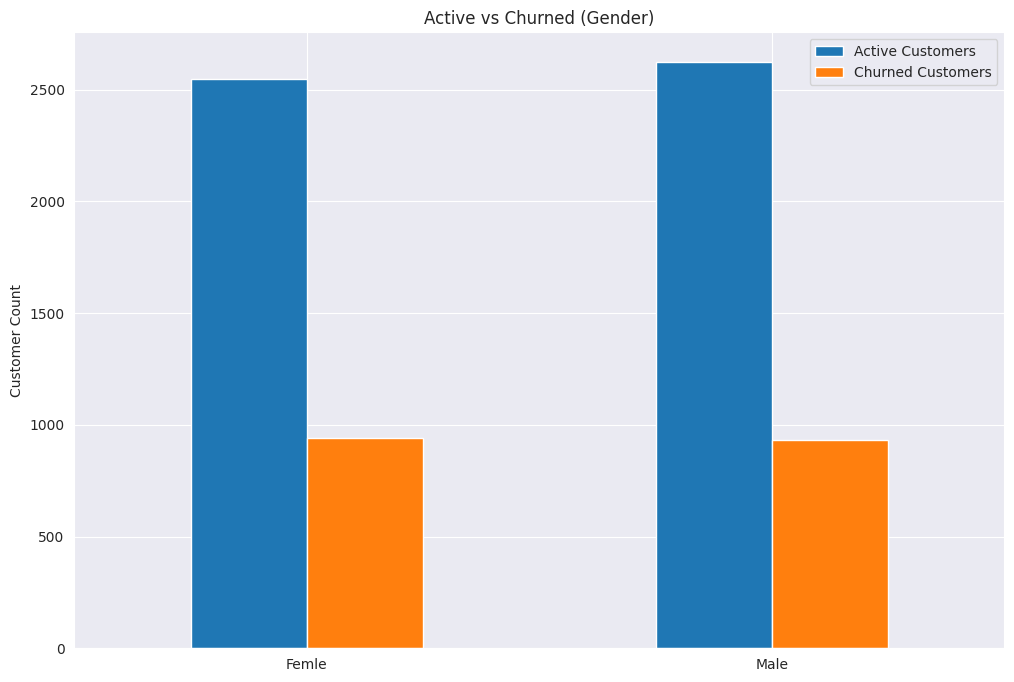

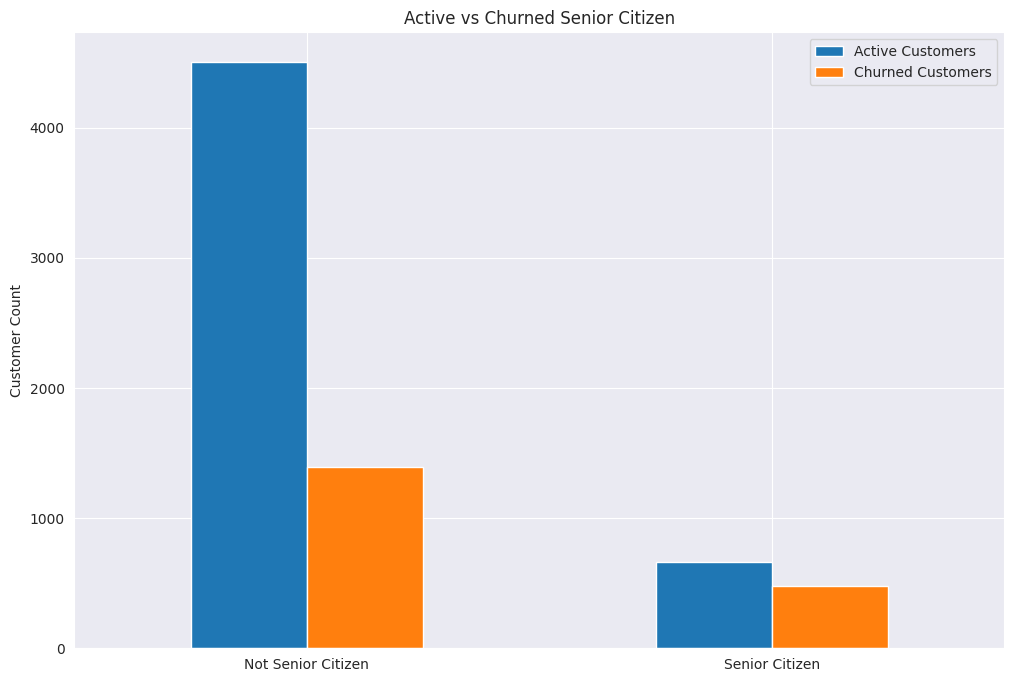

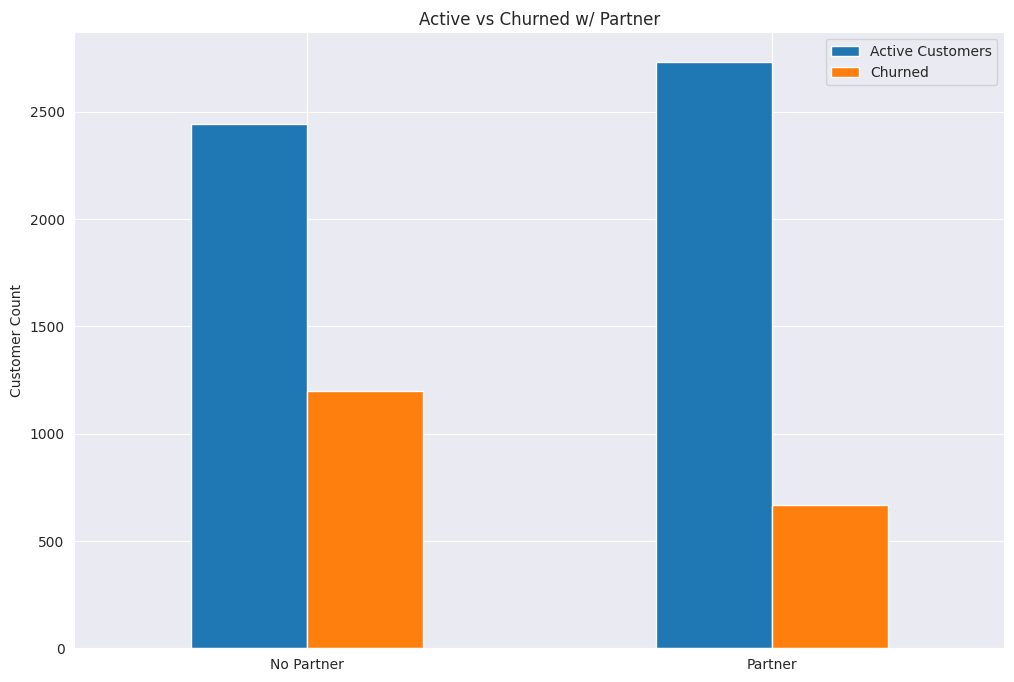

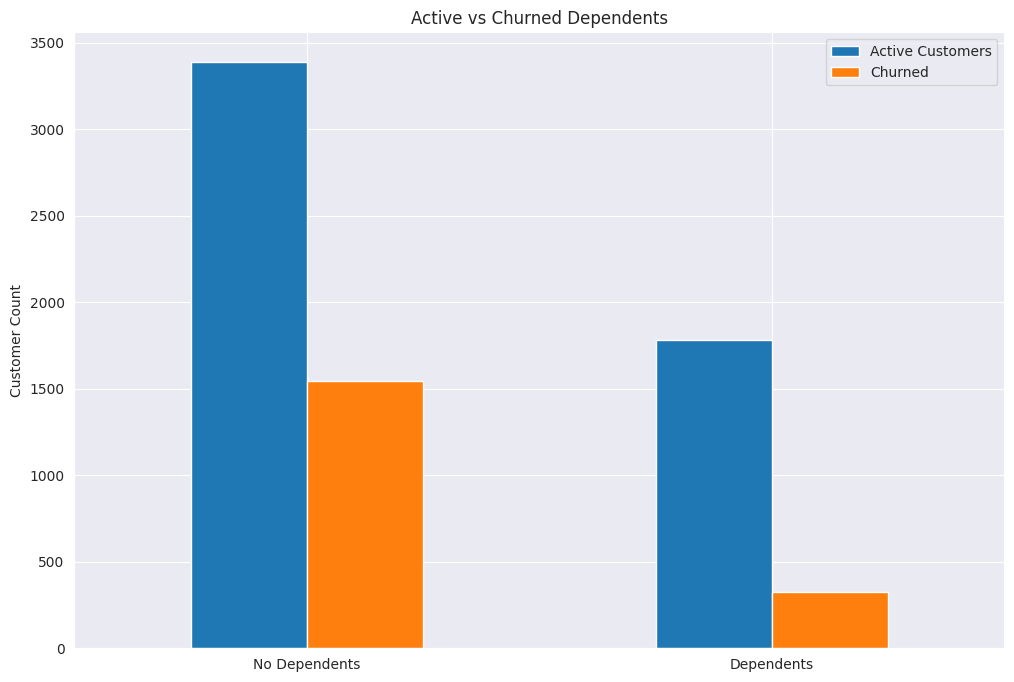

In [170]:
# Create bar charts for various customer demographics 
gender.plot(kind='bar',
           x='gender_male',
           title = 'Active vs Churned (Gender)',
           figsize= [12,8]
           )
plt.xticks([0,1], ['Femle', 'Male'],rotation=0)
plt.xlabel('')
plt.ylabel('Customer Count')
plt.legend(['Active Customers', 'Churned Customers'])

senior.plot(kind='bar',
           x='senior_citizen',
           title = 'Active vs Churned Senior Citizen',
           figsize= [12,8]
           )
plt.xticks([0,1], ['Not Senior Citizen', 'Senior Citizen'],rotation=0)
plt.xlabel('')
plt.ylabel('Customer Count')
plt.legend(['Active Customers', 'Churned Customers'])

partnership.plot(kind='bar',
            x='partner',
            title='Active vs Churned w/ Partner',
            figsize=[12,8]
            )
plt.xticks([0,1], ['No Partner', 'Partner'],rotation=0)
plt.xlabel('')
plt.ylabel('Customer Count')
plt.legend(['Active Customers', 'Churned'])

dependent.plot(kind='bar',
              x='dependents',
              title= 'Active vs Churned Dependents',
              figsize=[12,8]
              )
plt.xticks([0,1], ['No Dependents', 'Dependents'],rotation=0)
plt.xlabel('')
plt.ylabel('Customer Count')
plt.legend(['Active Customers', 'Churned'])

plt.show()

Description: The customer demographics show a fairly consistent pattern with active customers outnumbering the churned customers by a factor of two to four. However, an interesting exception exists among senior citizens as a larger percentage of them have chruned. This might be attributed to their advanced age meaning they may be deceased resulting in the cancellation of thier contracts. Another interesting trend is that those who have dependents or partners are least likely to churn. This may be due to the need for consitency in thier budget. 

Description: After exploring the data in the EDA phase, the following factors appear to be risk factors for churn: 
1. Senior citizen.
2. Fiber Optics users. 
3. Month to month contract users.
4. Users being charged 70-110.
5. Customers tended to leave within the frist few months of signing up. 
6. Majority of customers started to leave in October of 2019 up until January 2020.
Next, it will be important to complete some feature engineering to improve the outcome of the model training portion of the project. 

In [171]:
#Feature engineering: Create contract length based on begin_date 
now = df_merged['begin_date'].max()
df_merged['end_date']=df_merged['end_date'].fillna(now)
length = ((df_merged['end_date'] - df_merged['begin_date']) / np.timedelta64(1, 'M'))
df_merged['tenure']=length.round()
df_merged['tenure']=df_merged['tenure'].astype(int)


In [172]:
#Feature engineering: Create column for yes_internet bc some customers do not
yes_internet = df_merged['internet_service']
df_merged['yes_internet']= yes_internet 
df_merged['yes_internet'] =df_merged['yes_internet'].where(df_merged['yes_internet']!='DSL',1)
df_merged['yes_internet'] =df_merged['yes_internet'].where(df_merged['yes_internet']!='Fiber optic',1)
df_merged['yes_internet']= df_merged['yes_internet'].where(df_merged['yes_internet']!='No Service',0)
df_merged['yes_internet'] = df_merged['yes_internet'].where(df_merged['yes_internet']!='None', 0)
df_merged['yes_internet'] = df_merged['yes_internet'].astype(int)

In [173]:
#Feature engineering: Create number of services column 
df_merged['number_of_services']= df_merged['online_security'] + df_merged['online_backup'] + df_merged['device_protection']+ df_merged['tech_support']+ + df_merged['streaming_tv'] + df_merged['streaming_movies'] + df_merged['yes_internet'] + df_merged['multiple_lines'] + df_merged['phone_serv']
df_merged['number_of_services']= df_merged['number_of_services'].astype(int) 



In [174]:
#Feature engineering: Create column of remaining months left in contract 
remaining_months = []

for index, row in df_merged.iterrows():
    if row['contract_type'] == 'Monthly':
        months = 72 - row['tenure']
        remaining_months.append(months)
    elif row['contract_type'] == 'One year':
        if row['tenure'] <= 12:
            months = 12 - row['tenure']
            remaining_months.append(months)
        else:
            remaining_months.append(0)  # Default value for unhandled cases
    elif row['contract_type'] == 'Two year':
        if row['tenure'] <= 24:
            months = 24 - row['tenure']
            remaining_months.append(months)
        else:
            remaining_months.append(0)  # Default value for unhandled cases
    else:
        remaining_months.append(0)  # Default for any other contract types

df_merged['remaining_months'] = remaining_months

In [175]:
#Feature engineering: Create average charge based on total_charges and tenure 
df_merged['average_charge'] = (df_merged['total_charges']/df_merged['tenure']).round(2)
median = df_merged['average_charge'].median()
df_merged['average_charge'] = df_merged['total_charges'].fillna(median)

In [176]:
# Feature engineering: Calculate extra charges from difference bw total charges and monthly charges times tenure
df_merged['additional_charges']=(df_merged['total_charges']-(df_merged['monthly_charges'] * df_merged['tenure']))

In [177]:
# Feature engineering: Calculation for price per service
df_merged['price_for_each_service'] = (df_merged['monthly_charges']/df_merged['number_of_services'])


In [178]:
# Feature engineering: Devise variables to support with mathmatical transformation for model fitting 
df_merged['variable_a']=np.sqrt(df_merged['monthly_charges']) *df_merged['number_of_services']
df_merged['variable_b']=np.sqrt(df_merged['tenure']) * df_merged['number_of_services']
df_merged['variable_c']=np.sqrt(df_merged['monthly_charges'])*df_merged['number_of_services']
df_merged['variable_d']=np.sqrt(df_merged['tenure'])*df_merged['number_of_services']
df_merged['variable_e']=np.sqrt(df_merged['number_of_services'])/(df_merged['remaining_months']+1)
df_merged['variable_f']=np.sqrt(df_merged['monthly_charges'])/(df_merged['yes_internet']+df_merged['phone_serv'])
df_merged['variable_g']=df_merged['number_of_services']/np.sqrt(df_merged['tenure']+ 1)
df_merged['variable_h']=np.sqrt(df_merged['number_of_services'])/df_merged['monthly_charges']
df_merged['variable_i']=df_merged['price_for_each_service']*df_merged['tenure']


In [179]:
# Feature engineering: Devise a function to take into account outliers 
def replace_outliers(df,x_column):
    df_a = df[df['churn'] ==1]
    median_a = df_a[x_column].median()
    std_a = df_a[x_column].std()

    df_b = df[df['churn']==0]
    median_b = df_b[x_column].median()
    std_b = df_b[x_column].std()

    for index,row in df.iterrows():
        if row['churn']==1:
            if np.abs(row[x_column]-median_a) >2 *std_a:
                df.at[index,x_column]=median_a 

        if row['churn']==0:
            if np.abs(row[x_column]-median_b) > 2 * std_b:
                df.at[index, x_column] = median_b

    return df

In [180]:
# Feature engineering: Eliminating outliers 
df_merged = replace_outliers(df_merged,'monthly_charges')
df_merged = replace_outliers(df_merged,'total_charges')
df_merged = replace_outliers(df_merged,'average_charge')
df_merged = replace_outliers(df_merged,'additional_charges')
df_merged = replace_outliers(df_merged,'price_for_each_service')
df_merged = replace_outliers(df_merged,'variable_a')
df_merged = replace_outliers(df_merged,'variable_b')
df_merged = replace_outliers(df_merged,'variable_c')
df_merged = replace_outliers(df_merged,'variable_d')
df_merged = replace_outliers(df_merged,'variable_e')
df_merged = replace_outliers(df_merged,'variable_f')
df_merged = replace_outliers(df_merged,'variable_g')
df_merged = replace_outliers(df_merged,'variable_h')

df_merged = replace_outliers(df_merged,'variable_h')

In [181]:
# Feature engineering: OHE 
drop_cols = df_merged.drop(['customer_id','begin_date','end_date','contract_time_months'],axis=1).drop_duplicates()
data_ohe = pd.get_dummies(drop_cols,drop_first=True)

Description:A function was devised to eliminate outliers. Outliers were replaced with median vlaues for the columns. These outliers were identified based on whether the values indicated churn or not. Testing showed that applying the replace outlier function to the variable_h column increased performance leading to its use for model fitting and testing. 

In [182]:
# Train/Test Split 
train, valid = train_test_split(data_ohe,test_size=0.2,random_state=42,stratify=data_ohe['churn'])
train,test = train_test_split(train,test_size=0.25, random_state=42,stratify=train['churn'])

Description: A 3:1:1 ratio will be used for training, validation and testing data. 

In [183]:
# Check on distribution 
display(train['churn'].value_counts())
display(valid['churn'].value_counts())
display(test['churn'].value_counts())

0    3104
1    1121
Name: churn, dtype: int64

0    1035
1     374
Name: churn, dtype: int64

0    1035
1     374
Name: churn, dtype: int64

In [184]:
#Check on percent of churned customers included in the dataset 
display(1121/3104)
display(374/1035)

0.36114690721649484

0.36135265700483093

Description: The training, validation and testing sets have 36% chruned customers in each of the datasets. 

In [185]:
#Defining features and target

features_train=train.drop('churn',axis=1)
target_train = train['churn']
features_valid = valid.drop('churn',axis=1)
target_valid = valid['churn']
features_test = test.drop('churn',axis=1)
target_test = test['churn']


In [186]:
#Scale numerical data in preparation for models 
numeric_data = ['monthly_charges', 'total_charges','tenure', 'number_of_services','remaining_months','average_charge', 'additional_charges','variable_a','variable_b','variable_c','variable_d','variable_e','variable_f','variable_g','variable_h','variable_i']
scaler =StandardScaler()
scaler.fit(features_train[numeric_data])
features_train[numeric_data]=scaler.transform(features_train[numeric_data])
features_valid[numeric_data]=scaler.transform(features_valid[numeric_data])
features_test[numeric_data] = scaler.transform(features_test[numeric_data])



Description: Data has been scaled/normalized to enhance model performance. 

In [187]:
#Train Models: Logistic Regression 
lr_model = LogisticRegression(random_state=12345, solver='liblinear')
lr_model.fit(features_train, target_train)
lr_predicted_valid = lr_model.predict(features_valid)

accuracy_score_lr = accuracy_score(target_valid, lr_predicted_valid)

print('Accuracy Score:',accuracy_score_lr )
probabilities_valid_lr = lr_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid_lr[:,1]
auc_roc_lr = roc_auc_score(target_valid,probabilities_one_valid)

print('ROC-AUC:', auc_roc_lr)

Accuracy Score: 0.9048970901348474
ROC-AUC: 0.964902219122168


Description: This is the most straightforward of the models and will provide a baseline for the performance of the other models. The accuracy score and ROC-AUC score are high indicating a high level of predictive accuracy and precision. 

In [188]:
#Train Models: Decision Tree Classifier 
dtc_model=DecisionTreeClassifier(random_state=54321)

param_grid = {
    'max_depth':[None,10,20],
    'min_samples_split':[2,5,10]
}
grid_search = GridSearchCV(dtc_model,param_grid, cv=5, scoring='roc_auc')

grid_search.fit(features_train,target_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_ 

predicted_valid_dtc = best_model.predict(features_valid)
probabilities_valid = best_model.predict_proba(features_valid)[:,1]

accuracy_score_dtc = accuracy_score(target_test,predicted_valid_dtc)

print('Best Hyperparameters:', best_params) 
print('Accuracy Score:', accuracy_score_dtc)
auc_roc_dtc = roc_auc_score(target_test,probabilities_valid)
print('ROC AUC Score:',auc_roc_dtc)

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10}
Accuracy Score: 0.6266855926188787
ROC AUC Score: 0.5087072773773541


In [189]:
# Using hypertuned parameters 
best_dtc_model = DecisionTreeClassifier(random_state=54321, max_depth=10, min_samples_split=10)
best_dtc_model.fit(features_train,target_train)

best_dtc_probabilities = best_dtc_model.predict(features_valid)
best_dtc_one_probabilities = best_dtc_model.predict_proba(features_valid)[:,1]

best_accuracy_score_dtc = accuracy_score(target_test,predicted_valid_dtc)

best_dtc_auc_roc = roc_auc_score(target_valid, best_dtc_one_probabilities)

print('Accuracy Score:',best_accuracy_score_dtc)
print('ROC AUC Score:',best_dtc_auc_roc)


Accuracy Score: 0.6266855926188787
ROC AUC Score: 0.9558771861840916


Description: As observed previously there is a signficantly smaller number of customers who have left. This manifest in the accuracy score which indicates that the classes are imbalanced. However, the ROC AUC score is impressive and showcases that the model is adept at differentiating between churn and non-churn customers. It effectively identifies high risk customers ensuring accurate targeting. 

In [190]:
#Train Models: Random Forest Classifier 
model=RandomForestClassifier(random_state=12345)

param_grid = {
    'n_estimators':[100,150,200],
    'max_depth':[None,10,20],
    'min_samples_split':[2,5,10]
}
grid_search = GridSearchCV(model,param_grid, cv=5, scoring='roc_auc')

grid_search.fit(features_train,target_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_ 

predicted_valid_rf = best_model.predict(features_valid)
probabilities_valid = best_model.predict_proba(features_valid)[:,1]

accuracy_score_rf = accuracy_score(target_test,predicted_valid_rf)

print('Best Hyperparameters:', best_params) 
print('Accuracy Score:', accuracy_score_rf)
auc_roc_rf = roc_auc_score(target_test,probabilities_valid)
print('ROC AUC Score:',auc_roc_rf)

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 150}
Accuracy Score: 0.6202980837473385
ROC AUC Score: 0.5064739466273993


In [191]:
# Using hypertuned parameters 
best_rf_model = RandomForestClassifier(random_state=12345, max_depth =10, min_samples_split=2, n_estimators=200)
best_rf_model.fit(features_train,target_train)

best_rf_probabilities = best_rf_model.predict(features_valid)
best_rf_one_probabilities = best_rf_model.predict_proba(features_valid)[:,1]

best_accuracy_score_rf = accuracy_score(target_test,predicted_valid_dtc)

best_rf_auc_roc = roc_auc_score(target_valid, best_rf_one_probabilities)

print('Accuracy Score:',best_accuracy_score_rf)
print('ROC AUC Score:',best_rf_auc_roc)


Accuracy Score: 0.6266855926188787
ROC AUC Score: 0.9738975432070061


Description: Again the imbalanced dataset impacts the accuracy score. The accuracy score is better than random chance, however it is still very low. The ROC AUC score signfies that the model is highly capable of differentiating between customers who are likely to churn and those least likely to churn. 

In [192]:
#Train Models: LightGMB 
lgmb_model = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=12345)
lgmb_model.fit(features_train,target_train)
lgmb_predicted_valid = lgmb_model.predict(features_valid)

accuracy_score_lgmb = accuracy_score(target_valid,lgmb_predicted_valid)
print('Accuracy Score:',accuracy_score_lgmb )

probabilities_valid_lgmb = lgmb_model.predict_proba(features_valid)
probabilities_one_valid_lgmb = probabilities_valid_lgmb [:, 1]
auc_roc_lgmb = roc_auc_score(target_valid,probabilities_one_valid_lgmb)
print('ROC-AUC:',auc_roc_lgmb)


Accuracy Score: 0.9063165365507452
ROC-AUC: 0.9758970781988685


Description: This model has strong predictive abilities and a strong ability to identify customers who are likely to churn. 

In [193]:
#Train Models: CatBoost Classifer 
cat_model = CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6, loss_function='Logloss', random_state=12345)
cat_model.fit(features_train,target_train)
cat_predicted_valid = cat_model.predict(features_valid)

accuracy_score_cat = accuracy_score(target_valid,cat_predicted_valid)
print('Accuracy Score:', accuracy_score_cat)

probabilities_valid_cat = cat_model.predict_proba(features_valid)
probabilities_one_valid_cat = probabilities_valid_cat [:, 1]
auc_roc_cat = roc_auc_score(target_valid,probabilities_one_valid_cat)
print('ROC-AUC:',auc_roc_cat)

0:	learn: 0.5747936	total: 3.11ms	remaining: 619ms
1:	learn: 0.4686397	total: 5.78ms	remaining: 572ms
2:	learn: 0.4017461	total: 8.13ms	remaining: 534ms
3:	learn: 0.3530482	total: 10.5ms	remaining: 512ms
4:	learn: 0.3112793	total: 12.8ms	remaining: 498ms
5:	learn: 0.2818228	total: 15.1ms	remaining: 487ms
6:	learn: 0.2579370	total: 17.4ms	remaining: 480ms
7:	learn: 0.2421478	total: 19.8ms	remaining: 474ms
8:	learn: 0.2297580	total: 22.1ms	remaining: 468ms
9:	learn: 0.2228922	total: 24.4ms	remaining: 463ms
10:	learn: 0.2142965	total: 26.8ms	remaining: 460ms
11:	learn: 0.2068965	total: 29.1ms	remaining: 456ms
12:	learn: 0.2007988	total: 31.4ms	remaining: 451ms
13:	learn: 0.1961139	total: 33.6ms	remaining: 447ms
14:	learn: 0.1930005	total: 35.9ms	remaining: 442ms
15:	learn: 0.1894255	total: 38.2ms	remaining: 439ms
16:	learn: 0.1861351	total: 40.5ms	remaining: 436ms
17:	learn: 0.1829750	total: 43ms	remaining: 435ms
18:	learn: 0.1807921	total: 45.3ms	remaining: 432ms
19:	learn: 0.1793606	tot

Description: This model illustrates a keen ability to forecast and pinpoint which customers are at risk of leaving. 

In [194]:
# Train models: XGBClassifier
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1,max_depth=6, random_state=12345)
xgb_model.fit(features_train,target_train)
xgb_predicted_valid = xgb_model.predict(features_valid)

accuracy_score_xgb = accuracy_score(target_valid,xgb_predicted_valid)
print('Accuracy Score:', accuracy_score_xgb)

probabilities_valid_xgb = xgb_model.predict_proba(features_valid)
probabilities_one_valid_xgb = probabilities_valid_xgb [:, 1]
auc_roc_xgb = roc_auc_score(target_valid,probabilities_one_valid_xgb)
print('ROC-AUC:',auc_roc_xgb)

[16:49:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score: 0.9134137686302342
ROC-AUC: 0.9769782221188871


Description:This model showcases strong predictive abilities and is effective at identifying customers who may churn. Next, I will devise a table to identify which model performed then best based on accuracy score and ROC-AUC score. 

In [195]:
#Info 
models_examined = ['Linear Regression', 'Decision Tree', 'Random Forest', 'LGBM', 'CatBoost', 'XGBoost']
models_accuracy_score = [accuracy_score_lr,best_accuracy_score_dtc, best_accuracy_score_rf,accuracy_score_lgmb,accuracy_score_cat,accuracy_score_xgb ]
models_roc_auc_score = [auc_roc_lr,best_dtc_auc_roc,best_rf_auc_roc,auc_roc_lgmb,auc_roc_cat,auc_roc_xgb]

#Dataframe creation 
comparison = pd.DataFrame(
    {'Models': models_examined,
     'Accuracy Score':models_accuracy_score, 
     'ROC-AUC':models_roc_auc_score,
})
  
display (comparison)

,Models,Accuracy Score,ROC-AUC
0,Linear Regression,0.904897,0.964902
1,Decision Tree,0.626686,0.955877
2,Random Forest,0.626686,0.973898
3,LGBM,0.906317,0.975897
4,CatBoost,0.916253,0.977863
5,XGBoost,0.913414,0.976978


Description: In examining the various machine learning models two key metrics were evaluated to determine model performance: accuracy score and ROC- AUC score. The accuracy score determins the percentage of corrct predictions, while the ROC-AUC score demonstrates the model's ability to distinguish between classes ranging from 0.5 (aka random chance) to 1.0. It becomes apparent that the Random Forest and Decision Tree models illustrate slightly better than chance accuracy, yet have high ROC AUC scores when hyperparameters are tuned. This would suggest that while it realiably seperates the two classes it is not effective at predicting the minority classes. Meanwhile, Liner Regression, LGBM, CatBoost and XGBoost demonstrate both excellence in accuracy and class distinction. The best performing model is Catboost. Therefore, I will retrain the CatBoost model on the train and validation sets with the same hyperparameters.

In [196]:
#Testing final model 
test_cat_model = CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6, loss_function='Logloss', random_state=12345)
test_cat_model.fit(features_train,target_train)
cat_predicted_test = test_cat_model.predict(features_test)

pred_valid_cat = test_cat_model.predict(features_test)

prob_valid_cat = test_cat_model.predict_proba(features_test)

prob_one_valid_cat = prob_valid_cat[:,1]
auc_roc_cat_final = roc_auc_score(target_test, prob_one_valid_cat)

accuracy_test_cat_score = accuracy_score(pred_valid_cat, target_test)

print('Accuracy:',accuracy_test_cat_score)
print('AUC-ROC score:',auc_roc_cat_final)



0:	learn: 0.5747936	total: 4.37ms	remaining: 869ms
1:	learn: 0.4686397	total: 8.34ms	remaining: 826ms
2:	learn: 0.4017461	total: 12ms	remaining: 788ms
3:	learn: 0.3530482	total: 15.6ms	remaining: 763ms
4:	learn: 0.3112793	total: 19.2ms	remaining: 747ms
5:	learn: 0.2818228	total: 22.7ms	remaining: 735ms
6:	learn: 0.2579370	total: 26.3ms	remaining: 725ms
7:	learn: 0.2421478	total: 29.9ms	remaining: 717ms
8:	learn: 0.2297580	total: 33.4ms	remaining: 708ms
9:	learn: 0.2228922	total: 36.9ms	remaining: 702ms
10:	learn: 0.2142965	total: 40.6ms	remaining: 698ms
11:	learn: 0.2068965	total: 43.2ms	remaining: 678ms
12:	learn: 0.2007988	total: 45.5ms	remaining: 654ms
13:	learn: 0.1961139	total: 47.7ms	remaining: 634ms
14:	learn: 0.1930005	total: 50ms	remaining: 616ms
15:	learn: 0.1894255	total: 52.3ms	remaining: 602ms
16:	learn: 0.1861351	total: 54.6ms	remaining: 588ms
17:	learn: 0.1829750	total: 56.9ms	remaining: 576ms
18:	learn: 0.1807921	total: 59.2ms	remaining: 564ms
19:	learn: 0.1793606	total

In [197]:
pred = test_cat_model.predict(features_test)
accuracy_score(target_test, pred)

0.907735982966643

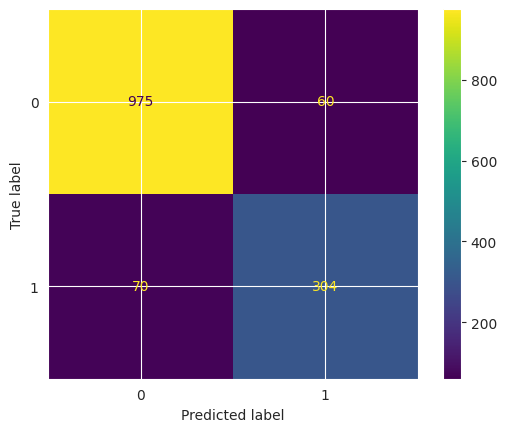

In [199]:
c_matrix = confusion_matrix(target_test, pred)
ConfusionMatrixDisplay(c_matrix).plot()
plt.show()

Conclusion: During the data preparation process all necessary libraries were loaded and the DataFrames were inspected for potential issues. This included checking for incorrectly named columns, ensuring correct datatypes, noting that date fields needed to be converted to datetime format, and realizing that camel case needed to be convereted to snake case. During preprocessing, all identified issues were addressed including converting binary data to a 1/0 format for streamlined processsing in subsequent phases. Following this, EDA was conducted, revealing signficant insights into risk factors associated iwth customer churn, notably demographic elements such as being a senior citizen and being charged in the $70-110 range. 

Next, feature engineering was conducted to enhance the training and development of predictive models. A variety of models were tested, including Linear Regression, Decision Tree, Random Forest, LightGBM, CatBoost and XGBoost. The CatBoost model emerged as the most effective model, achieving the highest accuracy and ROC-AUC scores. This means it not only had strong predictive accuracy, but was able to identify customers at high risk of churn. The performance of the CatBoost model, as demonstrated by the confusion matrix results, further confirms its effectiveness even in the presence of class imbalances. 